In [189]:
# Import the usual suspects.
import pandas as pd
import numpy as np
import os



In [201]:
# Read the individual file names from gatk results

raw_vcf_files= set(os.listdir("./../_resources/final/haplotypeCaller")[0:-1:2])
raw_vcf_genome_names = list(map( lambda elem : elem.split(".")[0], raw_vcf_files ))

raw_vcf_genome_names.remove('cohort')
raw_vcf_genome_names

['SRR8698491',
 'ERR760821',
 'ERR3148171',
 'ERR760761',
 'SRR9224942',
 'SRR8698480',
 'ERR779923',
 'ERR751419',
 'ERR760758',
 'ERR760783',
 'ERR751533',
 'SRR8698506',
 'ERR779914',
 'ERR3148153',
 'ERR751351',
 'ERR751410',
 'ERR751602',
 'SRR5535711',
 'SRR6389903',
 'ERR751459',
 'ERR751458',
 'ERR751436',
 'ERR3148188',
 'ERR3148164',
 'SRR9224992',
 'ERR760752',
 'ERR779909',
 'ERR775312',
 'ERR751476',
 'ERR760803',
 'ERR751454',
 'ERR760796',
 'ERR751398',
 'ERR751405',
 'SRR3732712',
 'ERR3148224',
 'SRR10851726',
 'ERR751363',
 'ERR751397',
 'ERR751434',
 'ERR751373',
 'ERR751352',
 'SRR10851598',
 'ERR850262',
 'ERR751525',
 'ERR779860',
 'ERR751394',
 'SRR9224958',
 'ERR776464',
 'ERR3148217',
 'ERR751501',
 'ERR751370',
 'SRR3732596',
 'ERR3148192',
 'NC000962_3',
 'ERR760868',
 'ERR751425',
 'ERR3148211',
 'ERR751389',
 'ERR751435',
 'SRR10851660',
 'SRR9224908',
 'ERR3148187',
 'SRR8698504',
 'SRR9224986',
 'SRR11947396',
 'cohort',
 'SRR9224952',
 'ERR751362',
 'ERR

In [202]:
# Read the final results file from tb-profiler results

raw_tbprofiler_combined_result = pd.read_json("./../_resources/raw/tbProfiler/tbprofiler.json", encoding="UTF-8")

In [203]:
# Isolate the common genome IDs using set difference
list_of_common_genome_ids= set(raw_tbprofiler_combined_result.columns.to_list()).intersection(set(raw_vcf_genome_names))

# list_of_common_genome_ids

# pd.DataFrame(list_of_common_genome_ids).to_json(path_or_buf= "./../_resources/synced/common_genome_ids.json", orient="values")


In [204]:
# Save the tb-profiler data only for the common genomes
synced_tbprofiler_df = (raw_tbprofiler_combined_result[list_of_common_genome_ids]).transpose()

synced_tbprofiler_df.to_json(path_or_buf= "./../_resources/synced/tbProfiler_combined_result.json")
synced_tbprofiler_df[['drtype']]

,drtype
SRR10851707,Sensitive
SRR3732596,Sensitive
ERR751356,MDR
ERR751456,MDR
ERR751482,MDR
...,...
ERR3148209,Drug-resistant
ERR751501,Drug-resistant
ERR775336,Sensitive
ERR775341,Drug-resistant


In [217]:
resistance_status_df = synced_tbprofiler_df[['drtype']]
resistance_status_df['isResistant'] = resistance_status_df.apply(lambda row: 0 if (row.drtype == 'Sensitive') else 1, axis = 1)
resistance_status_df = resistance_status_df.drop(['drtype'], axis=1)
resistance_status_df.head()


C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,isResistant
SRR10851707,0
SRR3732596,0
ERR751356,1
ERR751456,1
ERR751482,1


In [67]:
# Save only the VCF files which belong to the common genome IDs

# Using this code, create a txt file and then create a shell script to move all vcf files there
with open('./../_resources/synced/common_genome_ids.txt', 'w') as filehandle:
    for listitem in list_of_common_genome_ids:
        filehandle.write('%s\n' % listitem)

1


In [ ]:
# Read a vcf file

# PyVCF package
import vcf

vcf_reader = vcf.Reader(open("./cohort.bqsr.filter.snps.vcf"), 'r')

sample_1 = []

def extract_vcf_data (vcf_record):

    samples = record.samples
    # print(record.POS, " : ", record.alleles, " : ", samples[0].gt_alleles, " : ", samples[1].gt_alleles)
    sample_1.append(samples[1].gt_alleles)

    # first_allele_name = record.alleles[0]
    # second_allele_name =  str(record.alleles[1])
    #
    # first_allele_is_present = 1 if int(samples.gt_alleles[0]) == 1 else 0
    # second_allele_is_present = 1 if int(samples.gt_alleles[1]) == 1 else 0
    #
    #
    #
    # print(str(record.POS) + "_REF_" + first_allele_name + " : " , first_allele_is_present)
    # print(str(record.POS) + "_ALT_" + first_allele_name + " : " , int(not(first_allele_is_present)))
    #
    # print(str(record.POS) + "_REF_" + second_allele_name + " : " , second_allele_is_present)
    # print(str(record.POS) + "_ALT_" + second_allele_name + " : " , int(not(second_allele_is_present)))




# print( " POS : ", " ALLELES : ", " SAMPLE_1")
for record in vcf_reader:
    extract_vcf_data(record)

    # print("\n@@@@\n")

    # print('GT :', record.samples[0].gt_alleles)

set_of_alleles = set(tuple(row) for row in sample_1)

print(set_of_alleles)

# TODO create a cohort_snp_df
# TODO prune out NONE allele calls
# TODO prune out the complex allele calls


# {('0', '0'), ('1', '2'), ('1', '1'), (None, None), ('2', '2'), ('0', '1')}

# {('0', '0'), ('1', '2'), ('1', '1'), ('0', '2'), (None, None), ('2', '2'), ('0', '1')}

In [ ]:
import allel

cohort_snp_vcf = allel.read_vcf("cohort.bqsr.filter.snps.vcf")
for a_key in cohort_snp_vcf.keys():
    print(a_key)

# for i in zip(cohort_snp_vcf['variants/REF'], cohort_snp_vcf['variants/ALT']):
#     print(i[0], " : ", i[1][0])



In [ ]:
cohort_snp_df = allel.vcf_to_dataframe("cohort.bqsr.filter.snps.vcf", fields="*")
cohort_snp_df.columns


# cohort_snp_df.head()
# cohort_snp_vcf['calldata/GT']

In [ ]:
vcf_df = allel.vcf_to_dataframe("ERR751350.snps.vcf", fields="*")
vcf_df

In [ ]:
import allel
# see http://alimanfoo.github.io/2017/06/14/read-vcf.html for allel tutorial
import pandas as pd

vcf = allel.read_vcf("cohort.bqsr.filter.snps.vcf")

def vcf_get_index(vcf):
    """Return index as "CHR.POS"."""
    return [
        ".".join([chrom, str(pos)]) for chrom, pos in zip(
            vcf["variants/CHROM"],
            vcf["variants/POS"]
        )
    ]

def vcf_get_columns(vcf):
    """Return columns as "SAMPLE_ID"."""
    return vcf["samples"]

def vcf_to_snp_count(vcf):
    """Yield snp counts per sample, iterating over the snps in vcf."""
    for gt in vcf["calldata/GT"]:
        # GT value per allele is 0 if ref, >0 if alt.
        # see https://samtools.github.io/hts-specs/VCFv4.2.pdf section 1.4.2.
        n_snps = [sum(allele > 0) for allele in gt]
        yield n_snps

# TODO implement a function to only tell the nature of GT -> homo (0) or hetero (1)

snps_df = pd.DataFrame(
    vcf_to_snp_count(vcf),
    index=vcf_get_index(vcf),
    columns=vcf_get_columns(vcf)
)


In [ ]:
# snps['ERR3148226'].values
snps_df = snps_df.transpose()
snps_df.head()

In [ ]:
# snps_df.join(resistance_status_df)
final_df = resistance_status_df.join(snps_df)
final_df.head()
# snps_df.index.to_list()

In [ ]:
cols = list(final_df.columns)
cols = [*cols[1:], cols[0]]
final_df = final_df[cols]
final_df.head()



In [ ]:
final_df.to_json(path_or_buf= "final_df.json")

In [ ]:
final_df['isResistant'].value_counts().plot(kind='bar')



<AxesSubplot:>

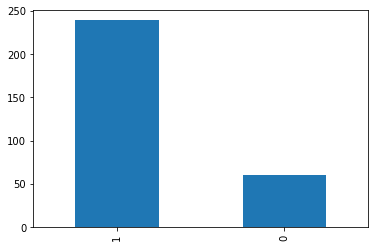

In [257]:
final_df['isResistant'].value_counts().plot(kind='bar')

